In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt
from torchvision.io import read_image
import json
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import albumentations as alb
import cv2
import numpy as np
import os
from torchvision import models
from torchsummary import summary
from torch import nn
from torch.optim import Adam

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
augmentor = alb.Compose([alb.RandomCrop(width=800, height=800), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [4]:
for folder in ['train','test']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [5]:
for partition in ['train','test']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(80):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                image_name = f'{image.split(".")[0]}.{x}.jpg'
                cv2.imwrite(os.path.join('aug_data', partition, 'images', image_name),  augmented['image'])

                annotation = {}
                annotation['image'] = image_name

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type


In [4]:
class FaceDataset(Dataset):
    def __init__(self, labels_dir, images_dir, transform=None):
        
        self.images_dir = images_dir
        self.transform = transform
        self.annotations = []

        for filename in os.listdir(labels_dir):
            if filename.endswith('.json'):
                json_path = os.path.join(labels_dir, filename)
                with open(json_path) as f:
                    data = json.load(f)
                    self.annotations.append(data)
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_info = self.annotations[idx]
        
        image = Image.open(os.path.join(self.images_dir, img_info['image'])).convert('RGB')
        bbox = img_info['bbox']
        boxes = torch.Tensor([bbox[0], bbox[1], bbox[2], bbox[3]])
        classes = img_info['class']

        if self.transform:
            image = self.transform(image)

        return image, (classes, boxes)

In [5]:
transform = transforms.Compose([
    Resize((240,240)),
    ToTensor()
    
])

training_data = FaceDataset(labels_dir='aug_data/train/labels',
                           images_dir='aug_data/train/images',
                           transform=transform)
testing_data = FaceDataset(labels_dir='aug_data/test/labels',
                           images_dir='aug_data/test/images',
                           transform=transform)

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=True)

In [7]:
train_features, (classes, bboxes) = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[2].squeeze()
label = bboxes[2]

img, label

Feature batch shape: torch.Size([64, 3, 240, 240])


(tensor([[[0.4314, 0.4353, 0.4353,  ..., 0.5137, 0.5137, 0.5137],
          [0.4314, 0.4353, 0.4353,  ..., 0.5137, 0.5137, 0.5137],
          [0.4314, 0.4353, 0.4353,  ..., 0.5137, 0.5137, 0.5137],
          ...,
          [0.5451, 0.5451, 0.5451,  ..., 0.8118, 0.8353, 0.8235],
          [0.5451, 0.5451, 0.5451,  ..., 0.8353, 0.8392, 0.8196],
          [0.5451, 0.5451, 0.5451,  ..., 0.8431, 0.8431, 0.8196]],
 
         [[0.4275, 0.4314, 0.4314,  ..., 0.5137, 0.5176, 0.5176],
          [0.4275, 0.4314, 0.4314,  ..., 0.5137, 0.5176, 0.5176],
          [0.4275, 0.4314, 0.4314,  ..., 0.5176, 0.5176, 0.5176],
          ...,
          [0.5725, 0.5686, 0.5686,  ..., 0.8039, 0.8314, 0.8196],
          [0.5686, 0.5647, 0.5647,  ..., 0.8235, 0.8353, 0.8118],
          [0.5647, 0.5647, 0.5647,  ..., 0.8314, 0.8353, 0.8039]],
 
         [[0.2471, 0.2510, 0.2549,  ..., 0.4000, 0.3961, 0.3961],
          [0.2471, 0.2510, 0.2549,  ..., 0.4000, 0.3961, 0.3961],
          [0.2471, 0.2510, 0.2510,  ...,

In [8]:
vgg16 = models.vgg16(pretrained=True)
model = vgg16.features

for param in model.parameters():
        param.requires_grad = False

summary(model, (3, 240, 240))

/opt/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 240, 240]        (1,792)
├─ReLU: 1-2                              [-1, 64, 240, 240]        --
├─Conv2d: 1-3                            [-1, 64, 240, 240]        (36,928)
├─ReLU: 1-4                              [-1, 64, 240, 240]        --
├─MaxPool2d: 1-5                         [-1, 64, 120, 120]        --
├─Conv2d: 1-6                            [-1, 128, 120, 120]       (73,856)
├─ReLU: 1-7                              [-1, 128, 120, 120]       --
├─Conv2d: 1-8                            [-1, 128, 120, 120]       (147,584)
├─ReLU: 1-9                              [-1, 128, 120, 120]       --
├─MaxPool2d: 1-10                        [-1, 128, 60, 60]         --
├─Conv2d: 1-11                           [-1, 256, 60, 60]         (295,168)
├─ReLU: 1-12                             [-1, 256, 60, 60]         --
├─Conv2d: 1-13                           [-1, 256, 60,

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 240, 240]        (1,792)
├─ReLU: 1-2                              [-1, 64, 240, 240]        --
├─Conv2d: 1-3                            [-1, 64, 240, 240]        (36,928)
├─ReLU: 1-4                              [-1, 64, 240, 240]        --
├─MaxPool2d: 1-5                         [-1, 64, 120, 120]        --
├─Conv2d: 1-6                            [-1, 128, 120, 120]       (73,856)
├─ReLU: 1-7                              [-1, 128, 120, 120]       --
├─Conv2d: 1-8                            [-1, 128, 120, 120]       (147,584)
├─ReLU: 1-9                              [-1, 128, 120, 120]       --
├─MaxPool2d: 1-10                        [-1, 128, 60, 60]         --
├─Conv2d: 1-11                           [-1, 256, 60, 60]         (295,168)
├─ReLU: 1-12                             [-1, 256, 60, 60]         --
├─Conv2d: 1-13                           [-1, 256, 60,

In [9]:
class FaceTracker(nn.Module):
    def __init__(self, vgg_model):
        super(FaceTracker, self).__init__()
        self.features = vgg_model

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        
        # Bounding box regression head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        class_output = self.classifier(x)
        bbox_output = self.regressor(x)
        return class_output, bbox_output

In [10]:
FaceTrackerModel = FaceTracker(model).to(device)

In [10]:
criterion_class = nn.BCELoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = Adam(FaceTrackerModel.parameters(), lr=0.0001)

In [11]:
def train(model, train_loader, criterion_class, criterion_bbox, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0.0
        total_class_loss = 0.0
        total_bbox_loss = 0.0
        
        for images, (classes, bboxes) in train_loader:
            images = images.to(device)
            classes = classes.to(device)
            bboxes = bboxes.to(device)

            optimizer.zero_grad()
            class_preds, bbox_preds = model(images)

            loss_class = criterion_class(class_preds.squeeze(), classes.float())
            loss_bbox = criterion_bbox(bbox_preds, bboxes)
            loss = loss_class + loss_bbox

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_class_loss += loss_class.item()
            total_bbox_loss += loss_bbox.item()
        
        avg_loss = total_loss / len(train_loader)
        avg_class_loss = total_class_loss / len(train_loader)
        avg_bbox_loss = total_bbox_loss / len(train_loader)
        
        print(f'Epoch {epoch+1}: Total Loss: {avg_loss:.4f}, Class Loss: {avg_class_loss:.4f}, BBox Loss: {avg_bbox_loss:.4f}')


In [15]:
def test(model, test_loader, criterion_class, criterion_bbox, device):
    model.eval()

    total_loss = 0.0
    total_class_loss = 0.0
    total_bbox_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, (classes, bboxes) in test_loader:
            images = images.to(device)
            classes = classes.to(device)
            bboxes = bboxes.to(device)

            class_preds, bbox_preds = model(images)

            loss_class = criterion_class(class_preds.squeeze(), classes.float())
            loss_bbox = criterion_bbox(bbox_preds, bboxes)
            loss = loss_class + loss_bbox

            total_loss += loss.item() * images.size(0)
            total_class_loss += loss_class.item() * images.size(0)
            total_bbox_loss += loss_bbox.item() * images.size(0)
            total_samples += images.size(0)

        avg_loss = total_loss / total_samples
        avg_class_loss = total_class_loss / total_samples
        avg_bbox_loss = total_bbox_loss / total_samples

    print(f'Test Results - Total Loss: {avg_loss:.4f}, Class Loss: {avg_class_loss:.4f}, BBox Loss: {avg_bbox_loss:.4f}')


In [11]:
FaceTrackerModel.train()
train_loader = train_dataloader

for epoch in range(10):
    total_loss = 0.0
    total_class_loss = 0.0
    total_bbox_loss = 0.0
        
    for images, (classes, bboxes) in train_loader:
        images = images.to(device)
        classes = classes.to(device)
        bboxes = bboxes.to(device)
            
        optimizer.zero_grad()
            
        class_preds, bbox_preds = FaceTrackerModel(images)
            
        loss_class = criterion_class(class_preds.squeeze(), classes.float())
        loss_bbox = criterion_bbox(bbox_preds, bboxes)
        
        loss = loss_class + loss_bbox
            
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
        total_class_loss += loss_class.item()
        total_bbox_loss += loss_bbox.item()
        
    avg_loss = total_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)
    avg_bbox_loss = total_bbox_loss / len(train_loader)
        
    print(f'Epoch {epoch+1}: Total Loss: {avg_loss:.4f}, Class Loss: {avg_class_loss:.4f}, BBox Loss: {avg_bbox_loss:.4f}')

Epoch 1: Total Loss: 0.2249, Class Loss: 0.2119, BBox Loss: 0.0130
Epoch 2: Total Loss: 0.1153, Class Loss: 0.1082, BBox Loss: 0.0070
Epoch 3: Total Loss: 0.0757, Class Loss: 0.0705, BBox Loss: 0.0052
Epoch 4: Total Loss: 0.0531, Class Loss: 0.0490, BBox Loss: 0.0041
Epoch 5: Total Loss: 0.0403, Class Loss: 0.0371, BBox Loss: 0.0033
Epoch 6: Total Loss: 0.0304, Class Loss: 0.0275, BBox Loss: 0.0028
Epoch 7: Total Loss: 0.0215, Class Loss: 0.0193, BBox Loss: 0.0022
Epoch 8: Total Loss: 0.0171, Class Loss: 0.0152, BBox Loss: 0.0019
Epoch 9: Total Loss: 0.0144, Class Loss: 0.0129, BBox Loss: 0.0016
Epoch 10: Total Loss: 0.0113, Class Loss: 0.0099, BBox Loss: 0.0014


In [12]:
torch.save(FaceTrackerModel.state_dict(), './models/test2.pth')

In [11]:
FaceTrackerModel.load_state_dict(torch.load('./models/test2.pth'))

<All keys matched successfully>

In [16]:
test(FaceTrackerModel, test_dataloader, criterion_class, criterion_bbox, device='mps')

Test Results - Total Loss: 0.0796, Class Loss: 0.0735, BBox Loss: 0.0061


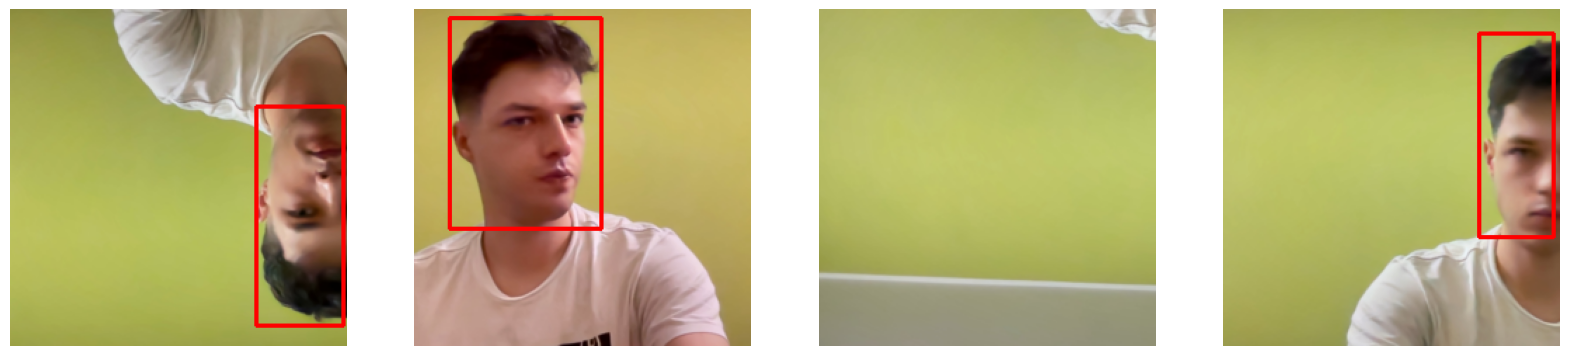

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
FaceTrackerModel.eval()

sample_images, _ = next(iter(train_dataloader))

for idx in range(4): 
    sample_image = sample_images[idx]
    mps_img = sample_image.to('mps').unsqueeze(0)
    
    class_pred, bbox_pred = FaceTrackerModel(mps_img)
    
    if class_pred > 0.5:
    
        bbox_pred = bbox_pred.squeeze(0).cpu().detach().numpy()
            
        start_point = tuple((bbox_pred[:2] * [240, 240]).astype(int))
        end_point = tuple((bbox_pred[2:] * [240, 240]).astype(int))
            
        sample_image_np = sample_image.permute(1, 2, 0).numpy()
        sample_image_np = (sample_image_np * 255).astype(np.uint8)
        sample_image_np = np.ascontiguousarray(sample_image_np)

        cv2.rectangle(sample_image_np, start_point, end_point, (255, 0, 0), 2)
            
        ax[idx].imshow(sample_image_np)
        ax[idx].axis('off')
    else:
        ax[idx].imshow(sample_image.permute(1, 2, 0))
        ax[idx].axis('off')
        
plt.show()
